# Predicting Beta Banks Customer's Behavior

# Content
* [Introduction](#introduction)
* [Data Exploration](#data_preprocessing)
    * [Conclusions](#conclusion)
* [Data Preprocessing](#preprocessing)
  * [Header style](#header)
  * [Missing values](#missing_values)
  * [Duplicates](#duplicates)
  * [Conclusions](#splitting_data_conclusions)
* [Feature Preparation](#feature_prep)
  * [Conclusions](#conclusions)
* [Training the Model](#training)
  * [Examining the balance of class](#balance)
  * [Decision Tree Classifier](#decision_tree)
  * [Random Forest](#random_forest)
  * [Logical Regression](#logical_regression)
  * [Conclusions](#conclusions)
* [Improving Quality of Model](#quality)
  * [Upsampling](#upsampling)
  * [Downsampling](#downsampling)
  * [Class weight adjustment](#class_weight)
  *[Conclusions](#conclusions)
* [Final Testing](#final_testing)
* [Findings](#conclusions)

## Introduction 

Beta Bank customers have been leaving, little by little, each month. The bankers learned that it's cheaper to save the existing customer's rather than to attract new customers. We will use machine learning to predict whether a customer will leave the bank. 

**Data Description:**

Features:

* `RowNumber` - data string index
* `CustomerId` - unique customer identifier
* `Surname` - surname
* `CreditScore` - credit score
* `Geography` - country of residence
* `Gender` - gender
* `Age` - age
* `Tenure` - period of maturation for a customer's fixed deposit (years)
* `Balance` - account balance
* `NumOfProducts` - number of banking products used by the customer
* `HasCrCard` - customer has a credit car
* `IsActiveMember` - customer's activeness
* `EstimatedSalary` - estimated salary 

Target:
* `Exited` - customer has left

**Objective:**

* Using the clients' past behavior and termination of contracts with the bank, predict whether a customer will leave the bank soon 

* Build a model with the maximum F1 score 

* Measure the AUC-ROC and compare it with the F1


## Initialization

In [581]:
# Loading all libraries 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve

In [582]:
# Loading the data
try:
  df = pd.read_csv('Churn.csv')
except:
  df = pd.read_csv('/datasets/Churn.csv')

## Data Exploration 

Description of data:

* `RowNumber` - data string index
* `CustomerId` - unique customer identifier
* `Surname` - surname
* `CreditScore` - credit score
* `Geography` - country of residence
* `Gender` - gender
* `Age` - age
* `Tenure` - period of maturation for a customer's fixed deposit (years)
* `Balance` - account balance
* `NumOfProducts` - number of banking products used by the customer
* `HasCrCard` - customer has a credit car
* `IsActiveMember` - customer's activeness
* `EstimatedSalary` - estimated salary 
* `Exited` - customer has left

In [583]:
# Obtaining the first 5 rows of the table
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [584]:
# Obtaining number of rows and columns
shape = df.shape
print('The dataset has {} rows and {} columns'.format(shape[0], shape[1]))

The dataset has 10000 rows and 14 columns


In [585]:
# Obtaining general info on the table
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Since our dataset has 10,000 rows, we can see that there are missing values in the `Tenure` column. 

In [586]:
# Percentage of missing values per column
df_mis = df.isna().sum().to_frame('missing values')
df_mis['%'] = round(100 * df.isna().sum()/len(df), 2)
print(df_mis.sort_values(by='%', ascending=False))

                 missing values     %
Tenure                      909  9.09
RowNumber                     0  0.00
CustomerId                    0  0.00
Surname                       0  0.00
CreditScore                   0  0.00
Geography                     0  0.00
Gender                        0  0.00
Age                           0  0.00
Balance                       0  0.00
NumOfProducts                 0  0.00
HasCrCard                     0  0.00
IsActiveMember                0  0.00
EstimatedSalary               0  0.00
Exited                        0  0.00


There are roughly 9% of missing values in the `Tenure` column. 

**Conclusions**

The dataset has 10,000 rows and 14 columns. Column names don't follow rules of good style, so change will be needed there. There is only one column with missing values. The `Tenure` column has 909 (~9%) of missing values.

Next we will preprocess the data to deal with missing values and check for duplicated data.

## Data Preprocessing

### Header Style

In [587]:
# Renaming columns
df.columns = df.columns.str.lower()
df = df.rename(columns={'rownumber':'row_number', 'customerid':'customer_id', 
                        'creditscore':'credit_score', 
                        'numofproducts':'num_of_products', 
                        'hascrcard':'has_cr_card', 
                        'isactivemember':'is_active_member', 'estimatedsalary':'estimated_salary'})

# Checking to see if columns have been properly renamed
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Missing values

In [588]:
# Calculating number of missing values 
df.isna().sum().sort_values(ascending=False)

tenure              909
row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

In [589]:
# Calculating the percentage of missing values for the tenure column 
mis_tenure = df['tenure'].isna().sum()/len(df)
print(f'Percentage of missing values in tenure column:{mis_tenure: .2%}')

Percentage of missing values in tenure column: 9.09%


In [590]:
# Getting unique values for the tenure column 
print(df['tenure'].unique())

[ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0. nan]


In [591]:
# Getting statistical summary of the tenure column 
df['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

Since there are no significant outliers in the `tenure` column, we will use the mean to replace the missing values.

In [592]:
# Replacing missing values in the tenure column 
tenure_avg = round(df['tenure'].mean())
df['tenure'].fillna(value=tenure_avg, inplace=True)

# Checking to see if missing values have been replaced
print(df['tenure'].unique())

[ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0.]


In [593]:
# Checking to make sure all missing values have been dealt with 
df.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

### Duplicates

In [594]:
# Checking for duplicates
df.duplicated().sum()

0

There are no duplicates in the dataset. 

**Conclusions**

We changed column names to lower case and added snake case to follow good rules of style.

Since there were no significant outliers in the `tenure` column, we replaced the missing values there with the mean. 

There were no duplicates in this dataset. 

Now that the data has been preprocessed and cleaned, we will now prepare our data for training.

## Feature Preparation 


In [595]:
# Dropping umimportant features
df = df.drop(['row_number', 'customer_id', 'surname'], axis=1)

# Checking to make sure columns were properly dropped
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [596]:
# Transforming categorical features into numerical features
df_ohe = pd.get_dummies(df, drop_first=True)

In [597]:
# Declaring variables for features and target
features = df_ohe.drop(['exited'], axis=1)
target= df_ohe['exited']

In [598]:
# Splitting the data into 60% training, 20% validation, 20% test set

# Splitting data into training and validation 
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.20, random_state=12345, stratify=target)

# Splitting data into training and testing 
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, test_size=0.25, random_state=12345, stratify=target_train)

In [599]:
# Checking to see if data was split properly
print('The training set contains {} rows'.format(features_train.shape[0]) + ', which represents 60% of the data')
print()
print('The validation set contains {} rows'.format(features_valid.shape[0]) + ', which represents 20% of the data')
print()
print('The test set contains {} rows'.format(features_test.shape[0]) + ', which represents 20% of the data')


The training set contains 6000 rows, which represents 60% of the data

The validation set contains 2000 rows, which represents 20% of the data

The test set contains 2000 rows, which represents 20% of the data


In [600]:
# Declaring numeric features in dataset
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary']

In [601]:
# Features scaling
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_36/2894192037.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_valid[numeric] = scaler.transform(features_valid[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [602]:
# Checking size of each features and target set
print('Size of training features:', features_train.shape)
print('Size of training target:', target_train.shape)
print()
print('Size of validation features:', features_valid.shape)
print('Size of validation target:', target_valid.shape)
print()
print('Size of test features:', features_test.shape)
print('Size of test target:', target_test.shape)

Size of training features: (6000, 11)
Size of training target: (6000,)

Size of validation features: (2000, 11)
Size of validation target: (2000,)

Size of test features: (2000, 11)
Size of test target: (2000,)


**Conclusions**

We encoded the categorical features using a special technique called One-Hot Encoding (OHE). The OHE technique allowed us to transform categorical features into numerical features.  When data is abundant, we have a chance of falling into the dummy feature trap. To avoid this, we removed safely any one column. 

We split the source data in a 3:1:1 ratio: 60% training set, 20% validation set, and 20% test set. 
* The training set contains 6000 rows
* The validation set contains 2000 rows
* The test set contains 2000 rows

We standardized the numerical features of the data. Now that the data is prepared, we can examine the balance of classes and train the model. 


## Training the Model

### Examining the balance of classes

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


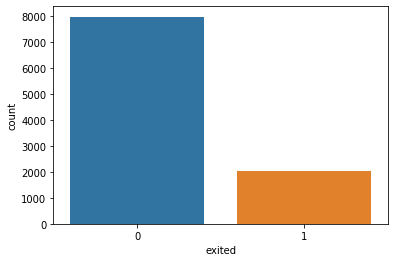

In [603]:
# Investigating the balance of classes
balance = sns.countplot(df_ohe['exited'])
plt.show()

We examined the balance of classes and can clearly see that there is a huge difference in dataset. There are almost 8000 customers that hasn't exited as compared to the 2000 that has. 

We will now train the model without taking the imbalance of classes into account. 

### Decision Tree Classifier 

In [604]:
# Tuning hyperparameters for Decision Tree Classifer
highest_accuracy = 0
best_depth = 0
for depth in range (1,50):
  model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
  model.fit(features_train, target_train)
  predictions_valid = model.predict(features_valid)
  accuracy = accuracy_score(target_valid, predictions_valid)
  if accuracy > highest_accuracy:
    highest_accuracy = accuracy
    best_depth = depth
print('Max depth = ', best_depth, ':', highest_accuracy)
    
# Calculating F1 score
print('F1 score:', f1_score(target_valid, predictions_valid))

# Calculating AUC-ROC score
probabilities_valid = model.predict_proba(features_valid)
probablities_one_valid = probabilities_valid[:,1]
print('AUC-ROC score:', roc_auc_score(target_valid, probablities_one_valid))

Max depth =  6 : 0.8595
F1 score: 0.49122807017543857
AUC-ROC score: 0.679580967716561


We found that a max depth of 6 produced the highest accuracy rate for the Decision Tree Classfier. The F1 score for the Decision Tree Classifier model is 51.6%.This is pretty low so we can say that both precision and recall are low. The AUC-ROC score is 0.69, meaning that the quality of the model can still be improved. 

### Random Forest 

In [605]:
# Tuning hyperparameters for Random Forest model
highest_accuracy = 0
max_n_estimators = 0
max_depth=0
for n in range(1,50):
  model = RandomForestClassifier(random_state=12345, n_estimators=n)
  model.fit(features_train, target_train)
  predictions_valid = model.predict(features_valid)
  accuracy = accuracy_score(target_valid, predictions_valid)
  if accuracy > highest_accuracy:
    highest_accuracy = accuracy 
    max_n_estimators = n
    max_depth = depth
print('n_estimators = ', max_n_estimators, ':',  'max_depth =', max_depth, ':', highest_accuracy)

# Calculating F1 score
print('F1 score:', f1_score(target_valid, predictions_valid))

# Calculating AUC-ROC score
probabilities_valid = model.predict_proba(features_valid)
probablities_one_valid = probabilities_valid[:,1]
print('AUC-ROC score:', roc_auc_score(target_valid, predictions_valid))

n_estimators =  47 : max_depth = 49 : 0.8625
F1 score: 0.5864661654135339
AUC-ROC score: 0.7197837282583045


We found that the a n_estimator of 43 and a max_depth of 49 produced the highest accuracy rate for the Random Forest model. The F1 score for the Random Forest model is higher than the Decision Tree Classifier model, at 57.6%.This is pretty low so we can say that both precision and recall are low. The AUC-ROC score is .71, which is means that the quality of the model can still be improved. 

### Logical Regression 

In [606]:
# Logical Regression model
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probablities_one_valid = probabilities_valid[:,1]
print('F1 score:', f1_score(target_valid, predictions_valid))
print('AUC-ROC score:', roc_auc_score(target_valid, predictions_valid))

F1 score: 0.29906542056074764
AUC-ROC score: 0.5832141849091003


The Logical Regression model has the lowest F1 score at 29.8%. We can say that both the precision and recall are low in this model. The AUC-ROC socre is .58, which means that model's quality still isn't great. 

**Conclusions**

The Random Forest model had the best F1 score at 57.6%, while the Logical Regression model had the worse F1 score at 29.8%. The Random Forest model has the highest AUC-ROC score at 0.71. 

We will now improve the quality of the model by fixing class imbalances.

## Improving Quality of the Model 

### Upsampling

Upsampling we synthetically generate data points (corresponding to minority class) to inject into the dataset. After this process, the counts of both labels are almost the same. 

In [607]:
# Defining function for upsampling
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


#  Creating new training sample
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

# Checking to see if our classes are more balanced 
target_upsampled.value_counts()

1    4892
0    4777
Name: exited, dtype: int64

In [608]:
# Decision Tree Classifier Model
model = DecisionTreeClassifier(random_state=12345, max_depth=6)
model.fit(features_upsampled, target_upsampled)

# Calculaing F1 score
predictions_valid = model.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

# Calculating AUC-ROC score
probabilities_valid = model.predict_proba(features_valid)
probablities_one_valid = probabilities_valid[:,1]
print('AUC-ROC score:', roc_auc_score(target_valid, probablities_one_valid))

F1 score: 0.5732142857142858
AUC-ROC score: 0.8409788833517646


The F1 score increased from 51.6% to 59.3%,and the AUC-ROC score has improved from .69 to .82, which means that the overall quality of the model has improved. 

In [609]:
# Random Forest Model 
model = RandomForestClassifier(random_state = 12345, n_estimators=43, max_depth=49)
model.fit(features_upsampled, target_upsampled)

# Calculating F1 score
predictions_valid = model.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

# Calculating AUC-ROC score
probabilities_valid = model.predict_proba(features_valid)
probabilities_valid_one = probabilities_valid[:,1]
print('AUC-ROC score:', roc_auc_score(target_valid, probabilities_valid_one))

F1 score: 0.5841184387617767
AUC-ROC score: 0.8532207091529125


The F1 score for the Random Forest model improved from 57.6% to 59.3%. The AUC-ROC score also increased from 0.71 to 0.85, which means the overall quality of the model has improved. 

In [610]:
# Logistical Regression Model
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)

# Calculating F1 score
predictions_valid = model.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

# Calculating AUC-ROC score
probabilities_valid = model.predict_proba(features_valid)
probabilities_valid_one = probabilities_valid[:,1]
print('AUC-ROC score:', roc_auc_score(target_valid, probabilities_valid_one))

F1 score: 0.5054393305439331
AUC-ROC score: 0.7812126456194253


The F1 score for the Logical Regression model increased from 29.8% to 50.4%. The AUC-ROC score also increased from 0.58 to 0.76, which means that the overall quality of the model has improved.

### Downsampling

Downsampling reduces the count of training samples falling under the majority class. This helps even up the counts of the target category.

In [611]:
# Creating function for downsampling
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

# Creating new training sample
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.255)

# Checking to see if our classes are balanced
target_downsampled.value_counts()

1    1223
0    1218
Name: exited, dtype: int64

In [612]:
# Decision Tree Classifier Model 
model = DecisionTreeClassifier(random_state=12345, max_depth=6)
model.fit(features_downsampled, target_downsampled)

# Calculaing F1 score
predictions_valid = model.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

# Calculating AUC-ROC score
probabilities_valid = model.predict_proba(features_valid)
probablities_one_valid = probabilities_valid[:,1]
print('AUC-ROC score:', roc_auc_score(target_valid, probablities_one_valid))

F1 score: 0.5855588526211671
AUC-ROC score: 0.8445841835672344


The F1 score for the Decision Tree Classifier Model increased from 51.6% to 57.5%, and the AUC-ROC score increase from .58 to .82. The overall quality of the model has increased. 

In [613]:
# Random Forest Model 
model = RandomForestClassifier(random_state=12345, n_estimators=43, max_depth=49)
model.fit(features_downsampled, target_downsampled)

# Calculaing F1 score
predictions_valid = model.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

# Calculating AUC-ROC score
probabilities_valid = model.predict_proba(features_valid)
probablities_one_valid = probabilities_valid[:,1]
print('AUC-ROC score:', roc_auc_score(target_valid, probablities_one_valid))

F1 score: 0.5914691943127961
AUC-ROC score: 0.8593593593593594


The F1 score for the Random Forest model improved from 57.6% to 60.1%. The AUC-ROC score also increased from 0.71 to 0.85, which means the overall quality of the model has improved.

In [614]:
# Linear Regression Model 
model = LogisticRegression(random_state=12345)
model.fit(features_downsampled, target_downsampled)

# Calculaing F1 score
predictions_valid = model.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

# Calculating AUC-ROC score
probabilities_valid = model.predict_proba(features_valid)
probablities_one_valid = probabilities_valid[:,1]
print('AUC-ROC score:', roc_auc_score(target_valid, probablities_one_valid))

F1 score: 0.5055131467345207
AUC-ROC score: 0.779218355489542


The F1 score for the Logical Regression model increased from 29.8% to 49.5%. The AUC-ROC score also increased from 0.58 to 0.77, which means that the overall quality of the model has improved.

### Class weight adjustment

We can use the argument class_weight='balanced' to penalize mistakes on the minority class by an amount proportional to how under-represented it is

In [615]:
# Decision Tree Classifier Model
model = DecisionTreeClassifier(random_state=12345, max_depth=11, class_weight='balanced')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

# Calculating the F1 score
print('F1 score:', f1_score(target_valid, predictions_valid))

# Calculating the AUC-ROC score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('AUC-ROC score:', roc_auc_score(target_valid, probabilities_one_valid))

F1 score: 0.5288065843621399
AUC-ROC score: 0.7270082100590576


The F1 score for the Decision Tree Classifier Model stayed increased from 51% to 52.5%, and the AUC_ROC score increased from 0.69 to 0.73. The overall quality of the model has increased.

In [616]:
# Random Forest Model
model = RandomForestClassifier(random_state=12345, n_estimators=43, max_depth=49, class_weight='balanced')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

# Calculating the F1 score
print('F1 score:', f1_score(target_valid, predictions_valid))

# Calculating the AUC-ROC score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('AUC-ROC score:', roc_auc_score(target_valid, probabilities_one_valid))

F1 score: 0.5529953917050691
AUC-ROC score: 0.8484624840557045


The F1 score for the Random Forest model decreased from 57.6% to 55.9%. The AUC-ROC score increased from 0.71 to 0.85, which means the overall quality of the model has improved.

In [617]:
# Logistical Regression model 
model = LogisticRegression(random_state=1234, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)

# Calculating the F1 score
predictions_valid = model.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

# Calculating the AUC-ROC score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('AUC-ROC score:', roc_auc_score(target_valid, probabilities_one_valid))



F1 score: 0.5072340425531915
AUC-ROC score: 0.7811247302772727


The F1 score for the Logical Regression model increased from 29.8% to 50.2%. The AUC-ROC score also increased from 0.58 to 0.76, which means that the overall quality of the model has improved.

**Conclusions**

We used three different techniques to fix class imbalance: upsampling, downsampling, and adjusting class weight.

Using upsampling, we found that the F1 score for the Decision Tree Classifier model increased from 51.6% to 59.3%, and the AUC-ROC score also increased from .69 to .82. The F1 score for the Random Forest model improved from 57.6% to 59.3%, and the AUC-ROC score increased from 0.71 to 0.85. The F1 score for the Logical Regression model increased from 29.8% to 50.4%, and the AUC-ROC score increased from 0.58 to 0.76.

Using downsampling, we found that the F1 score for the Decision Tree Classifier model increased from 51.6% to 57.5%, and that the AUC-ROC score stayed increased from 0.69 to 0.82. The F1 score for the Random Forest model increased from 57.6% to 61.5%, and the AUC-ROC score increased from 0.71 to 0.85. The F1 score for the Logical Regression model increased from 29.8% to 49.5%, and the AUC-ROC score increased from 0.58 to 0.77.

Using the argument, class_weight='balanced', we found that the F1 score increased from 51% to 52.5, and that the AUC-ROC score increased from 0.69 to 0.72. For the Random Forest model, we found that the F1 score decreased from 57.6% to 55.9%, but the AUC-ROC score increased from 0.71 to 0.85. The F1 score for the Logical Regression model increased from 29.8% to 50.2%, and the AUC-ROC score increased from 0.58 to 0.76. 

The F1 and AUC-ROC score was the best for the Decision Tree Classifier when using upsampling. The F1 and AUC-ROC score was the best for the Random Forest and Logical Regression model when using downsampling. Overall, the Random Forest model had the best F1 and AUC-ROC score.  


## Final Testing

In [618]:
# Random Forest Model
model = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth=49)
model.fit(features_downsampled, target_downsampled)
predictions_test = model.predict(features_test)

# Calculating the F1 score
f1_score = f1_score(target_test, predictions_test)
print('F1 Score:', f1_score)

F1 Score: 0.6003861003861004


AUC-ROC Score: 0.8635862364675924


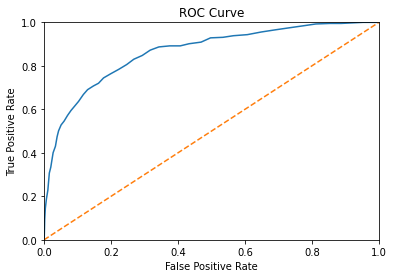

In [619]:
#ROC Curve
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

# Plotting the graph
plt.figure()
plt.plot(fpr,tpr)

# ROC curve for a random model (looks like straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

# Setting boundaries for the axes from 0 to 1
plt.xlim([0,1])
plt.ylim([0,1])

# Adding title and axes label
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Roc-Auc Score
print('AUC-ROC Score:', roc_auc_score(target_test, probabilities_one_test))

The best model for our data was the Random Forest model after downsampling. The F1 score was 55.2% and the AUC-ROC score was 0.84. 

## Findings

Before training the data, we encoded the categorical features using OHE. To avoid falling into the dummy trap feature, we safely removed one column. We split the source data in a 3:1:1 ratio: 60% training set, 20% validation set, and 20% test set.
* The training set contains 6000 rows
* The validation set contains 2000 rows
* The test set contains 2000 rows
Lastly, we standardized the numerical features of the data. 


After examining the balance of classes, we saw that there was a huge difference in dataset. We trained the model without taking the imbalance of classes into account, and found that the Random Forest model had the best F1 score at 57.6% and the highest AUC-ROC score at 0.71. 


To improve the quality of the model, we employed three different techniques to fix class imbalance: upsampling, downsampling, and adjusting the class weight.
* Using upsampling, we found that the F1 and AUC-ROC score increased for the Decision Tree Classifier, the Random Forest,  and Logical Regression model.
* Using downsampling, we found that the F1 score and AUC-ROC score increased for the Decision Tree Classifier model, the Random Forest and Logical Regression model.
* Using the class_weight=’balanced’ argument, that F1 and AUC-ROC score for the Decision Tree Classifier, Random Forest and Logical Regression model. 

The F1 and AUC-ROC score was the best for the Decision Tree Classifier when using upsampling. The F1 and AUC-ROC score was the best for the Random Forest and Logical Regression model when using downsampling. Overall, the Random Forest produced the best F1 and AUC-ROC score. 

Upon final testing of the Random Forest model after upsampling, we found that the F1 score was 60.0% and that the AUC-ROC score was 0.84. An AUC-ROC score of 0.84 shows that the overall model of the quality has improved after fixing class imbalance. The model can now reliably predict whether a customer will leave the bank.
